In [44]:
import numpy as np
import pandas as pd
import os
import json
import h5py
import sys
import pdb
import argparse
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import seaborn as sns

import print_per_user_conf_mat
import data_utils

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# FDIR = '../openface_data/gest_data_38_2/correct_gests_38'
FDIR = '../openface_data/gest_data_38_2/correct_gests_38'
pred_h5 = '../conv_lstm/torch/final_experiments/1_vs_all/single_scale_conv_lstm/1_sigma/tilt/cp_train_24/pred.h5'
# pred_h5 = '/tmp/mohit_delete_3/cp_train_5/pred.h5'

VISUALIZE_ONE_ROC_CURVE = True
VISUALIZE_ALL_ROC_CURVE = True

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Get the probability distribution, prediction and targets

def get_target_and_score(prob, pred, target, main_target_label):
    # Get y_test, y_score
    y_test, y_score = [], []
    for f in prob.keys():
        prob_arr = np.array(prob[f])
        y_score += prob_arr[:,-1].tolist()
        for i in xrange(len(target[f])):
            if target[f][i] == main_target_label:
                y_test.append(1)
            else:
                y_test.append(0)
    assert len(y_test) == len(y_score), 'Test preds and score should have same length.'
    y_test = np.array(y_test)
    y_score = np.array(y_score)
    return y_test, y_score

if VISUALIZE_ONE_ROC_CURVE:
    prob, pred, target = print_per_user_conf_mat.get_all_user_predictions(FDIR, pred_h5)
    main_target_label = 2
    y_test, y_score = get_target_and_score(prob, pred, target, main_target_label)

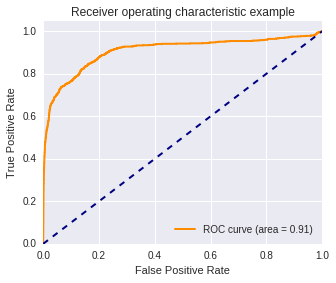

In [46]:
# Compute ROC curve and ROC area for each class
if VISUALIZE_ONE_ROC_CURVE:
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Compute micro-average ROC curve and ROC area
    # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"] )

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

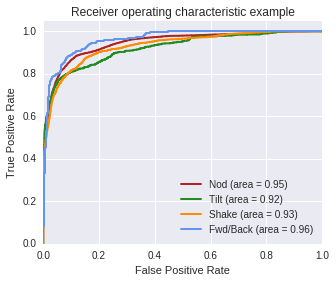

In [49]:
nod_pred_h5 = '../conv_lstm/torch/final_experiments/1_vs_all/multi_scale_conv_lstm/1_vs_all_nod_1_sigma/cp_train_30/pred.h5'
nod_target_label = 1

tilt_pred_h5 = '../conv_lstm/torch/final_experiments/1_vs_all/multi_scale_conv_lstm/1_vs_all_tilt_gest_list_1_sigma/cp_train_27/pred.h5'
tilt_target_label = 2

shake_pred_h5 = '../conv_lstm/torch/final_experiments/1_vs_all/multi_scale_conv_lstm/1_vs_all_shake_gest_list_1_sigma/cp_train_32/pred.h5'
shake_target_label = 3

fwd_back_pred_h5 = '../conv_lstm/torch/final_experiments/1_vs_all/multi_scale_conv_lstm/1_vs_all_fwd_back_gest_list_1_sigma/cp_train_32/pred.h5'
fwd_back_target_label = 4

all_pred_h5 = [nod_pred_h5, tilt_pred_h5, shake_pred_h5, fwd_back_pred_h5]
all_target_label = [nod_target_label, tilt_target_label, shake_target_label, fwd_back_target_label]
all_names = ['Nod', 'Tilt', 'Shake', 'Fwd/Back']
# Colors: https://matplotlib.org/examples/color/named_colors.html
all_colors = ['firebrick', 'forestgreen', 'darkorange', 'cornflowerblue']

if VISUALIZE_ALL_ROC_CURVE:
    y_test, y_score = {}, {}
    fpr, tpr = {}, {}
    roc_auc = {}
    for i in xrange(len(all_pred_h5)):
        prob, pred, target = print_per_user_conf_mat.get_all_user_predictions(FDIR, all_pred_h5[i])
        y_test[i], y_score[i] = get_target_and_score(prob, pred, target, all_target_label[i])
        
        fpr[i], tpr[i], _ = roc_curve(y_test[i], y_score[i])

        roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"] )

        if i == 0:
            plt.figure()
        lw = 2
        plt.plot(fpr[i], tpr[i], color=all_colors[i],
                 lw=lw, label='{} (area = {:.2f})'.format(all_names[i], roc_auc[i]))
        #plt.plot(fpr[i], tpr[i], color=all_colors[i],
        #         lw=lw, label='{}'.format(all_names[i]))
        # plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()